In [1]:
from units import *
import matplotlib.pyplot as plt
from astrometry_sim import QuasarSim
import healpy as hp
from pylab import cm
from estimator_wholesky import get_vector_alm
from tqdm import *
from astropy import units as u

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [71]:
max_sep = 2
nside = 128
lmax = 3*nside - 1
nsim = 1

sim = []

for isim in tqdm_notebook(range(nsim)):
#     sim.append(QuasarSim(n_sh=1, sh_m_frac=0.2, max_sep=max_sep, m_delta=1e6*M_s, verbose=True, sh_distrib='MW', sim_uniform=True, nside=nside, 
#                          custom_coords=[[0*u.deg],[0*u.deg],[1*u.mas/u.year],[1*u.mas/u.year],[100*kpc]]))
#     sim.append(QuasarSim(sh_m_frac=0.2, max_sep=max_sep, m_delta=1e8*M_s, verbose=True, sh_distrib='MW', sim_uniform=True, nside=nside, c200_delta=10000, save_powerspecs=True))
    sim.append(QuasarSim(alpha_m=1.9, n_calib=150, max_sep=max_sep, verbose=True, sh_distrib='Aq1', m_min=1e-5, sim_uniform=True, nside=nside))


A Jupyter Widget

A Jupyter Widget

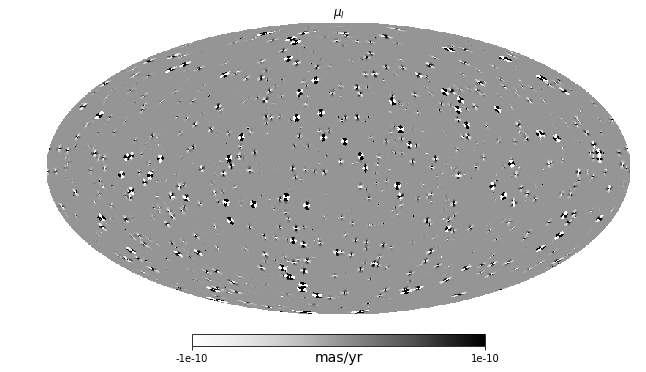

In [72]:
maxx = 10**(-10)

cmap = cm.Greys
cmap.set_under('w')

for i in range((nsim)):

    hp.mollview(sim[i].mu_qsrs[:,0],max=maxx, min=-maxx, title="$\mu_l$", unit='mas/yr', cmap=cmap)
# hp.mollview(sim[0].mu_qsrs[:,1],max=maxx, min=-maxx, title="$\mu_b$", unit='mas/yr', cmap=cmap)

No handles with labels found to put in legend.


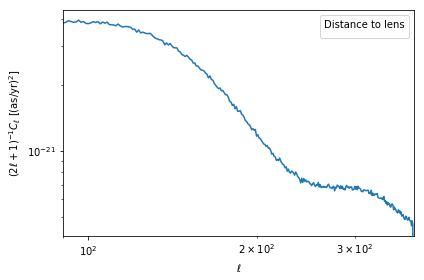

In [69]:
ell = np.arange(len(sim[0].Cl_B))

plt.plot(ell, sim[0].Cl_B/(2*ell + 1))

plt.yscale("log")
plt.xscale("log")
plt.xlim(180/max_sep, lmax)
plt.ylabel("$(2\ell + 1)^{-1} C_\ell$ [(as/yr)$^2$]")
plt.xlabel("$\ell$")
plt.legend(title='Distance to lens')
# plt.title('Gaussian lens, $R_0$ = 1 kpc, $M_0 = 10^8\,\mathrm{M}_\odot$, $\dot\\theta$ = 1 mas/yr')
plt.tight_layout()
# plt.savefig("Gauss.pdf")

No handles with labels found to put in legend.


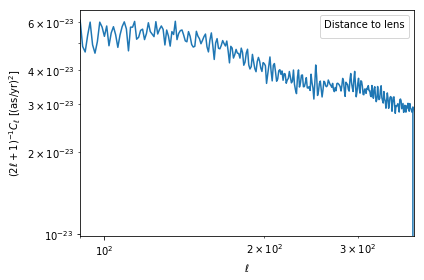

In [73]:
ell = np.arange(len(sim[0].Cl_B))

plt.plot(ell, sim[0].Cl_B/(2*ell + 1))

plt.yscale("log")
plt.xscale("log")
plt.xlim(180/max_sep, lmax)
plt.ylabel("$(2\ell + 1)^{-1} C_\ell$ [(as/yr)$^2$]")
plt.xlabel("$\ell$")
plt.legend(title='Distance to lens')
# plt.title('Gaussian lens, $R_0$ = 1 kpc, $M_0 = 10^8\,\mathrm{M}_\odot$, $\dot\\theta$ = 1 mas/yr')
plt.tight_layout()
# plt.savefig("Gauss.pdf")

In [57]:
Cl_B_ary, Cl_C_ary, fB_ary, fC_ary = [],[],[],[]
for isim in tqdm_notebook(range(nsim)):
    Cl_B, Cl_C, fB, fC = get_vector_alm(sim[isim].mu_qsrs[:,1], sim[isim].mu_qsrs[:,0])
    Cl_B_ary.append(Cl_B)
    Cl_C_ary.append(Cl_C)
    fB_ary.append(fB)
    fC_ary.append(fC)

A Jupyter Widget

/home/sm8383/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0.5,1,'$\\log_{10}(\\Psi_{lm}\\,[mas/yr])$')

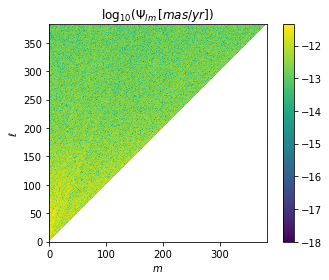

In [58]:
plt.imshow((np.log10(np.abs(fB))), origin='lower', vmin=-18)
cbar = plt.colorbar()

plt.xlabel("$m$")
plt.ylabel("$\ell$")

plt.title("$\log_{10}(\Psi_{lm}\,[mas/yr])$")

/home/sm8383/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sm8383/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


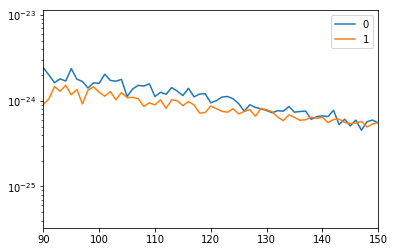

In [59]:
nch = 2
ch = np.transpose([[np.mean(split_ary) for split_ary in np.array_split((np.abs(fB)**2)[l][:l], nch)] for l in range(lmax)])
ell = np.arange(len(ch[0]))

for ich in range(nch):
    plt.plot(ell, 2*ch[ich], label=str(ich))
# plt.plot(ell, 1e6*Cl_tot[1:]*ell*(ell+1), label="Tot", color='grey', alpha=0.9)

plt.legend()
plt.xlim((180/max_sep), 150)
# plt.ylim(1e-32,1e-27)
# plt.xscale("log")
plt.yscale("log")

Text(0.5,0,'$\\ell$')

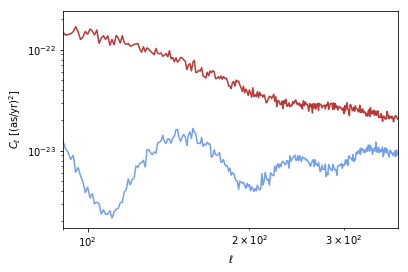

In [60]:
ell = np.arange(len(Cl_B_ary[0]))

plt.plot(ell, np.mean(Cl_B_ary, axis=0), color='firebrick', alpha=0.9)
plt.plot(ell, np.mean(Cl_C_ary, axis=0), color='cornflowerblue', alpha=0.9)

# plt.legend()
plt.xlim((180/max_sep), lmax-5.)
# plt.ylim(1e-30,4e-24)
plt.xscale("log")
plt.yscale("log")

plt.ylabel("$C_\ell$ [(as/yr)$^2$]")
plt.xlabel("$\ell$")

# plt.title("Expected signal, $10^{10}$ M$_\odot$ subhalo 10 kpc away")

Text(0.5,0,'$\\ell$')

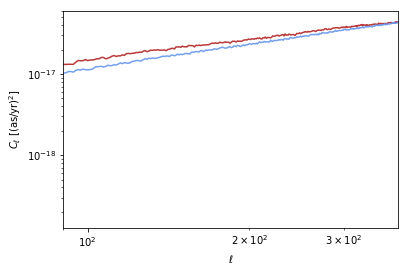

In [53]:
ell = np.arange(len(Cl_B_ary[0]))

plt.plot(ell, np.mean(Cl_B_ary, axis=0), color='firebrick', alpha=0.9)
plt.plot(ell, np.mean(Cl_C_ary, axis=0), color='cornflowerblue', alpha=0.9)

# plt.legend()
plt.xlim((180/max_sep), lmax-5.)
# plt.ylim(1e-30,4e-24)
plt.xscale("log")
plt.yscale("log")

plt.ylabel("$C_\ell$ [(as/yr)$^2$]")
plt.xlabel("$\ell$")

# plt.title("Expected signal, $10^{10}$ M$_\odot$ subhalo 10 kpc away")

In [18]:
# ell = np.arange(len(Cl_B_ary[0]))

# plt.plot(ell, np.mean(Cl_B_ary, axis=0), color='firebrick', alpha=0.9)
# plt.plot(ell, np.mean(Cl_C_ary, axis=0), color='cornflowerblue', alpha=0.9)

# # plt.legend()
# plt.xlim((180/max_sep), lmax-5.)
# plt.ylim(1e-28,4e-24)
# plt.xscale("log")
# plt.yscale("log")

# plt.ylabel("$C_\ell$ [(mas/yr)$^2$]")
# plt.xlabel("$\ell$")

# # plt.title("Expected signal, $10^{10}$ M$_\odot$ subhalo 10 kpc away")

In [133]:
# ell = np.arange(len(Cl_B))

# plt.plot(ell, 1e6*Cl_B, label="$\Psi$-comp", color='cornflowerblue', alpha=0.9)
# plt.plot(ell, 1e6*Cl_C, label="$\Phi$-comp", color='firebrick', alpha=0.9)
# # plt.plot(ell, 1e6*Cl_tot[1:]*ell*(ell+1), label="Tot", color='grey', alpha=0.9)

# plt.legend()
# plt.xlim((180/max_sep), lmax/2.)
# # plt.ylim(0,4e-23)
# plt.xscale("log")
# plt.yscale("log")

# plt.ylabel("$C_\ell$ [(mas/yr)$^2$]")
# plt.xlabel("$\ell$")

# # plt.title("Expected signal, $10^{10}$ M$_\odot$ subhalo 10 kpc away")

Annual Modulation

In [398]:
from tqdm import *

In [413]:
def norm(idx, maxidx = 9, minidx = 0):
    return (idx - minidx) / float(maxidx - minidx)

In [475]:
def get_ma(vec):
    return (np.max(vec, axis=0)  - np.min(vec, axis=0))/np.mean(vec, axis = 0)

In [480]:
# max_sep = 5
# nside = 128
# lmax = 3*nside - 1

# Cl_B_nfw = []
# Cl_C_nfw = []

# for t in tqdm_notebook(np.linspace(0,365.25,10)):
#     sim = QuasarSim(n_sh = 1, sh_m_frac=1e-4, max_sep=max_sep, m_delta=1e7*M_s, verbose=True, sh_distrib='MW', sim_uniform=True, nside=nside, t=t)
#     Cl_B, Cl_C, fB, fC = get_vector_alm(sim.mu_qsrs[:,1], sim.mu_qsrs[:,0])
#     Cl_B_nfw.append(Cl_B)
#     Cl_C_nfw.append(Cl_C)
    
Cl_B_compact = []
Cl_C_compact = []

for t in tqdm_notebook(np.linspace(0,365.25,10)):
    sim = QuasarSim(n_sh = 1, sh_m_frac=1e-4, max_sep=max_sep, m_delta=1e7*M_s, verbose=True, c200_delta=100000., sh_distrib='MW', sim_uniform=True, nside=nside, t=t)
    Cl_B, Cl_C, fB, fC = get_vector_alm(sim.mu_qsrs[:,1], sim.mu_qsrs[:,0])
    Cl_B_compact.append(Cl_B)
    Cl_C_compact.append(Cl_C)

In [490]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(edgeitems=3, linewidth=200) 

In [21]:
asctorad**2

2.3504430539097885e-11

Text(0.5,1,'Power spectrum annual modulation')

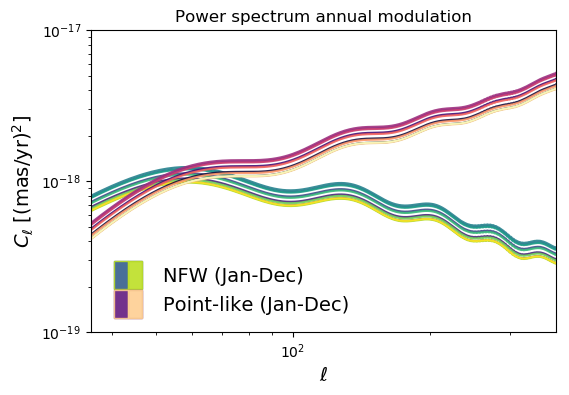

In [529]:
ell = np.arange(len(Cl_B))

plt.figure(num=None, figsize=(6,4), dpi=100, facecolor='w', edgecolor='k')

m3, = plt.plot([], [], c=plt.cm.magma(0.3) , marker='s', markersize=20,
              fillstyle='left', linestyle='none',alpha=0.9)

m4, = plt.plot([], [], c=plt.cm.magma(0.9)  , marker='s', markersize=20,
              fillstyle='right', linestyle='none',alpha=0.9)

m1, = plt.plot([], [], c=plt.cm.viridis(0.3) , marker='s', markersize=20,
              fillstyle='left', linestyle='none',alpha=0.9)

m2, = plt.plot([], [], c=plt.cm.viridis(0.9)  , marker='s', markersize=20,
              fillstyle='right', linestyle='none',alpha=0.9)

for i in range(10):
    color = plt.cm.viridis(norm(i))
    plt.plot(ell, 1e6*Cl_B_nfw[i], color=color, alpha=0.9)

for i in range(10):
    color = plt.cm.magma(norm(i))
    plt.plot(ell, 1e6*Cl_B_compact[i], color=color, alpha=0.9)

# for i in range(10):
#     plt.plot(ell, 1e6*Cl_B_maxw[i], color='firebrick', alpha=0.9)

# plt.plot(ell, 1e6*Cl_C_vec[0], label="$\Phi$-comp", color='firebrick', alpha=0.9)
# plt.plot(ell, 1e6*Cl_tot[1:]*ell*(ell+1), label="Tot", color='grey', alpha=0.9)

handles = [(m1,m2),(m3,m4)] #, handles[2]]
labels = ['NFW (Jan-Dec)','Point-like (Jan-Dec)'] #, labels[2]]


leg = plt.legend(handles,labels,loc='lower left',fontsize=14,fancybox=True,facecolor='none',frameon=False)

plt.xlim((180/max_sep), lmax-5.)
# plt.ylim(0,4e-23)
plt.xscale("log")
plt.yscale("log")

plt.ylabel("$C_\ell$ [(mas/yr)$^2$]", fontsize=14)
plt.xlabel("$\ell$", fontsize=14)

plt.ylim(1e-19, 1e-17)

plt.title('Power spectrum annual modulation')
# plt.title("Expected signal, $10^{10}$ M$_\odot$ subhalo 10 kpc away")

Text(0.5,1.05,'Total power in $\\ell < 383$ from preferred velocity, point-like')

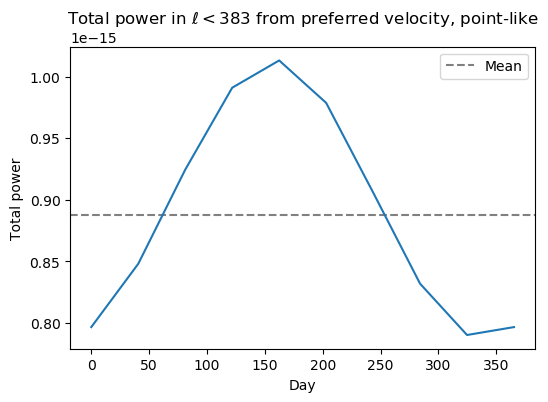

In [527]:
plt.figure(num=None, figsize=(6,4), dpi=100, facecolor='w', edgecolor='k')
plt.axhline(np.mean(1e6*np.sum(Cl_B_compact, axis = 1)), ls='--', color='grey', label='Mean')

plt.plot(np.linspace(0,365.25,10), 1e6*np.sum(Cl_B_compact, axis = 1))
plt.xlabel("Day")
plt.ylabel("Total power")
plt.legend()
plt.title('Total power in $\ell < 383$ from preferred velocity, point-like', y = 1.05)

/home/sm8383/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Text(0.5,0,'$\\ell$')

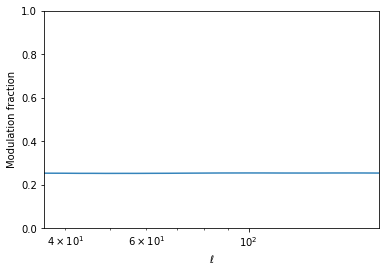

In [466]:
ell = np.arange(len(Cl_B))
plt.plot(ell, get_ma(Cl_B_delta), alpha=0.9)

# for i in range(10):
#     plt.plot(ell, 1e6*Cl_B_maxw[i], color='firebrick', alpha=0.9)

# plt.plot(ell, 1e6*Cl_C_vec[0], label="$\Phi$-comp", color='firebrick', alpha=0.9)
# plt.plot(ell, 1e6*Cl_tot[1:]*ell*(ell+1), label="Tot", color='grey', alpha=0.9)

# plt.legend()
plt.xlim((180/max_sep), lmax/2.)
plt.ylim(0,1)
plt.xscale("log")
# plt.yscale("log")

plt.ylabel("Modulation fraction")
plt.xlabel("$\ell$")

# plt.ylim(1e-19, 3e-18)

# plt.title("Expected signal, $10^{10}$ M$_\odot$ subhalo 10 kpc away")